In [21]:
from pathlib import Path

import jax.random as jr
import jax.numpy as jnp

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


base_dir = Path('/projectnb/dietzelab/arober/Bayesian-inference-with-surrogates')
base_out_dir = base_dir / 'out' / 'pde_experiment'

def read_samp(n_design, rep_idx, base_out_dir):
    out_dir = base_out_dir / f'n_design_{n_design}' / f'rep{rep_idx}'
    samp = dict(jnp.load(out_dir / 'samples.npz'))
    return samp

def samp_trace(n_design, rep_idx, base_out_dir):
    samp = read_samp(n_design, rep_idx, base_out_dir)
    for nm, vals in samp.items():
        for i in range(vals.shape[1]):
            plt.plot(vals[:,i])
        plt.title(nm)
        plt.show()


def samp_pair_plot(key, n_design, rep_idx, base_out_dir, dist_names=None):
    samp = read_samp(n_design, rep_idx, base_out_dir)
    samp['prior'] = jr.normal(key, samp['exact'].shape)

    if dist_names is None:
        dist_names = ['prior', 'ep_mcwmh', 'eup', 'mean', 'exact']
    par_names = [f'u{i}' for i in range(1, samp['exact'].shape[1]+1)]

    df_list = []
    for name in dist_names:
        df = pd.DataFrame(samp[name], columns=par_names)
        df['dist'] = name
        df_list.append(df)
    samp_df = pd.concat(df_list, ignore_index=True)

    sns.pairplot(samp_df, hue='dist', diag_kind='kde')


def summarize_status(n_design, base_out_dir):
    out_dir = base_out_dir / f'n_design_{n_design}'
    subdirs = [p for p in out_dir.iterdir() if p.is_dir() and p.name.startswith('rep')]
    completed = [(p / 'samples.npz').exists() for p in subdirs]

    print(f'n_design = {n_design}: {sum(completed)} of {len(completed)} completed.')

In [16]:
summarize_status(20, base_out_dir)

n_design = 20: 50 of 57 completed.


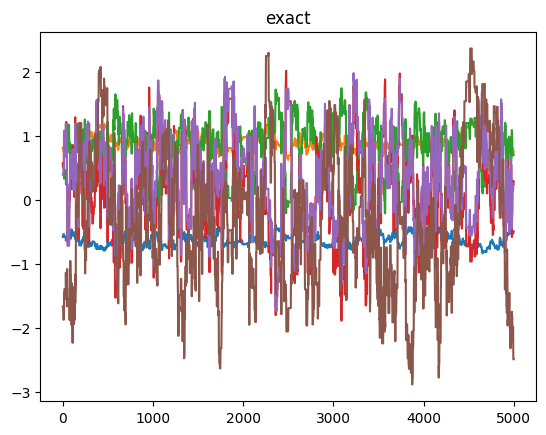

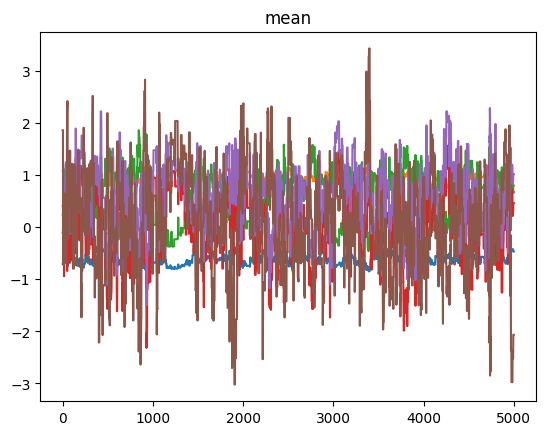

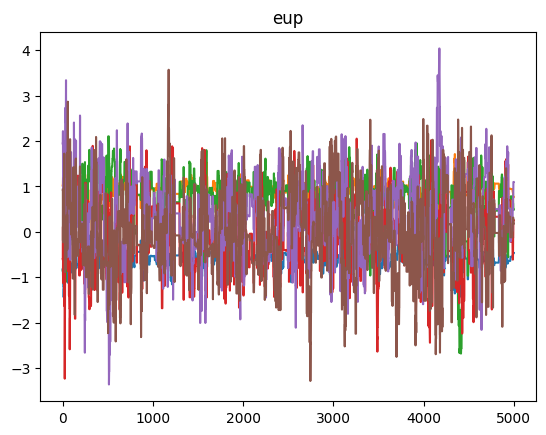

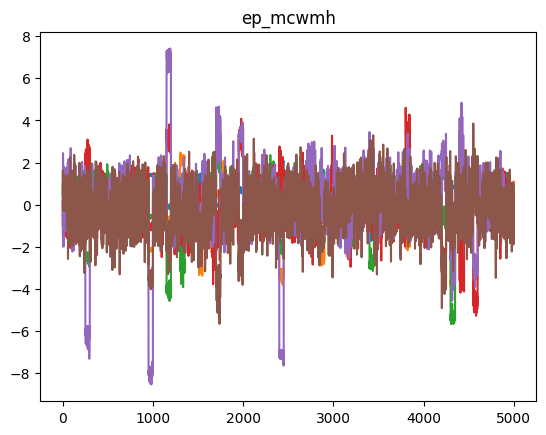

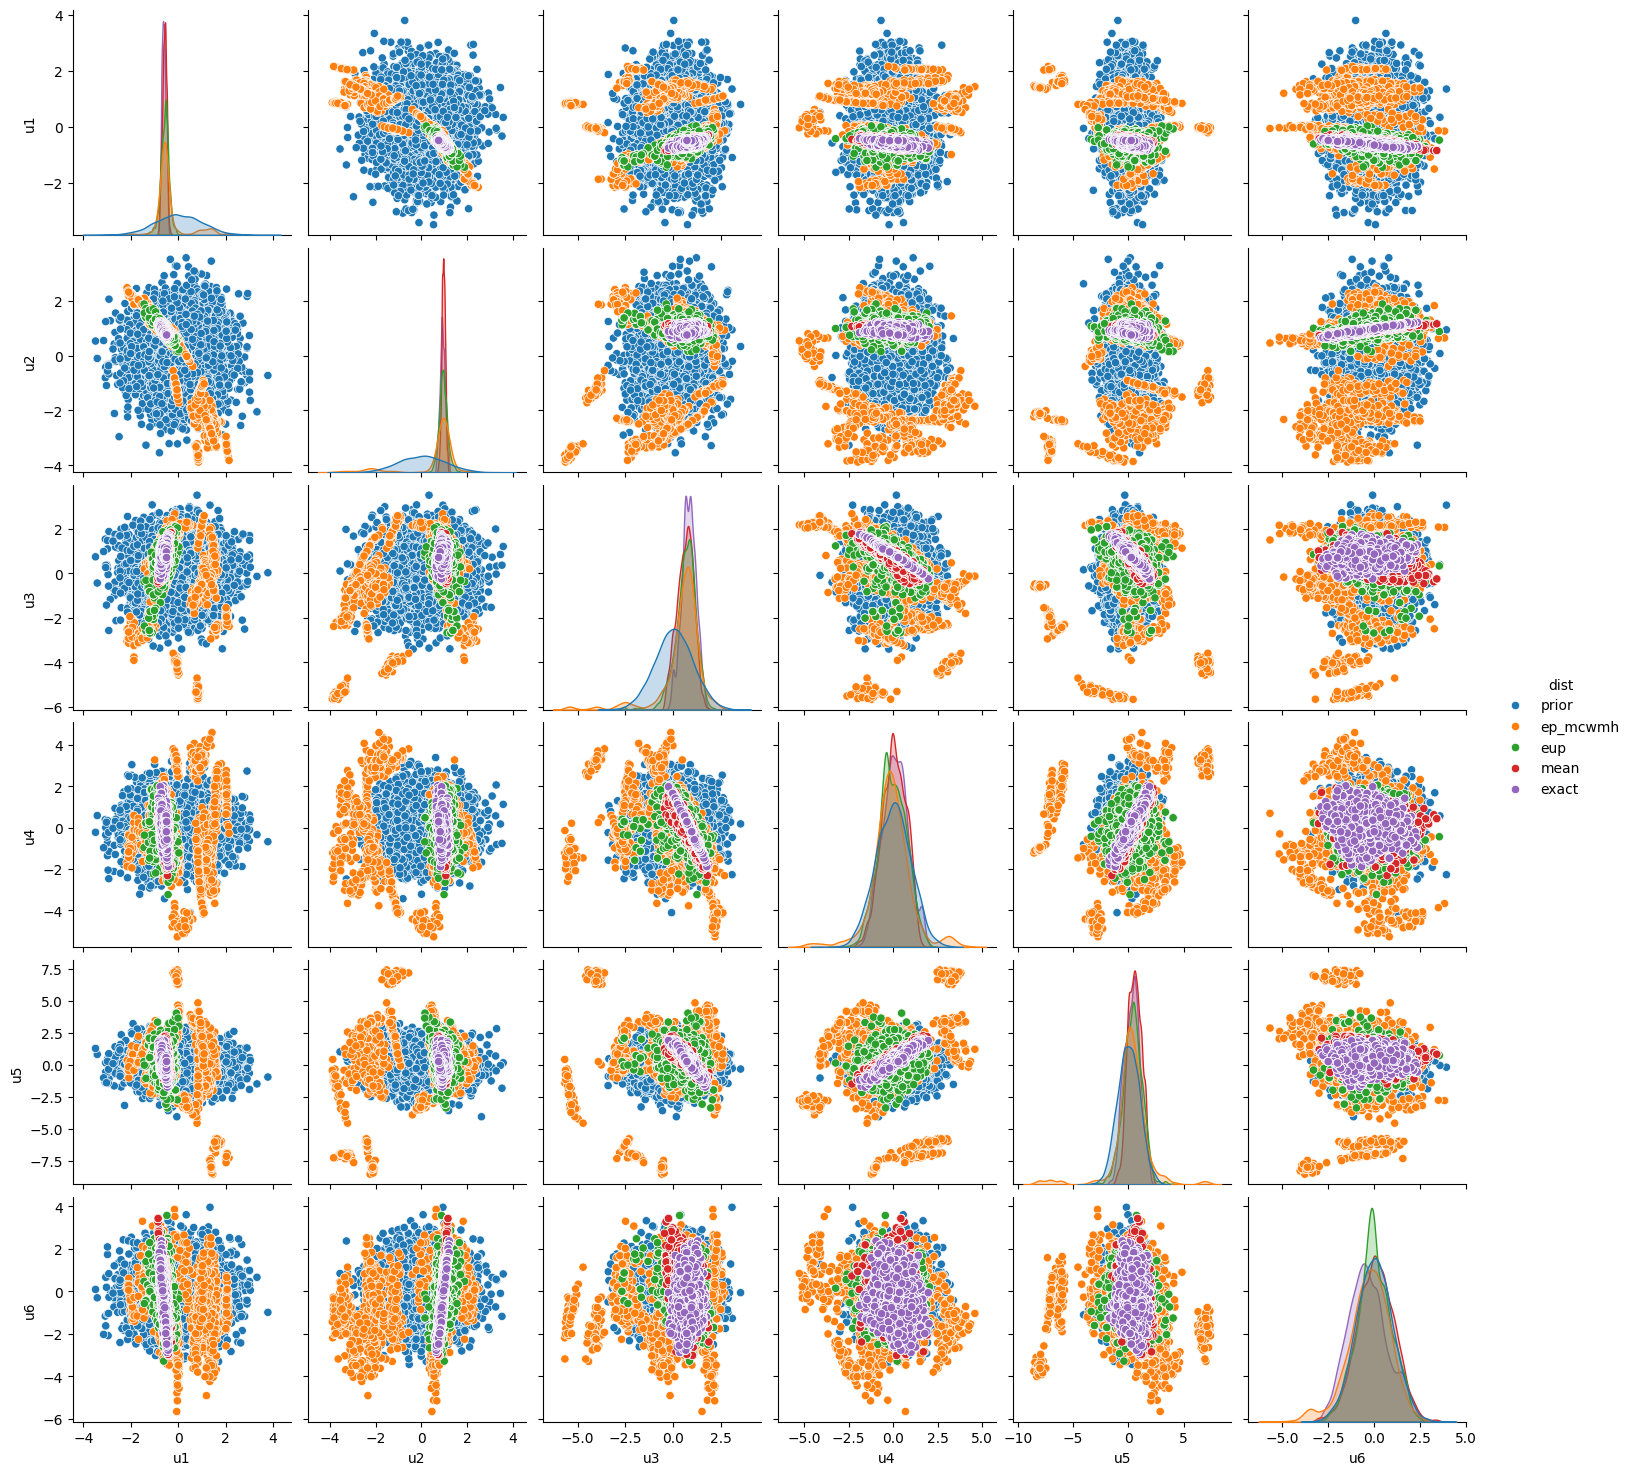

In [29]:
rep_idx = 1
design_idx = 20
key = jr.key(23532)

samp_trace(design_idx, rep_idx, base_out_dir)
samp_pair_plot(key, design_idx, rep_idx, base_out_dir)

In [9]:
samp = dict(read_samp(4, 0, base_out_dir))

### END TEMP

In [ ]:
from jax import config
config.update('jax_enable_x64', True)
from pathlib import Path

import jax
import jax.numpy as jnp
import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.distributions import MultivariateNormal

from uncprop.core.distribution import GaussianFromNumpyro
from uncprop.core.samplers import sample_distribution
from uncprop.utils.plot import set_plot_theme, smart_subplots
from uncprop.utils.grid import plot_coverage_curve_reps
from uncprop.models.elliptic_pde.inverse_problem import (
    PDESettings,
    generate_pde_inv_prob_rep,
    plot_inverse_problem_setup,
)

colors = set_plot_theme()
base_dir = Path('/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper')

from pde_model import (
    get_discrete_source, 
    solve_pde, 
    solve_pde_vmap,
)

In [ ]:
# settings 

key = jr.key(5232214)
noise_sd = 1e-2
n_kl_modes = 6
obs_locations = jnp.array([10, 30, 60, 75])

inv_prob_settings = {
    'noise_cov' : noise_sd**2 * jnp.identity(len(obs_locations)),
    'n_kl_modes': n_kl_modes,
    'obs_locations': obs_locations,
    'settings': PDESettings()
}
inv_prob_settings['key'] = key

In [ ]:
posterior, gp_prior, eig_info, ground_truth = generate_pde_inv_prob_rep(**inv_prob_settings)

In [ ]:
key, key_plot = jr.split(key)

fig, ax = plot_inverse_problem_setup(key=key_plot,
                                     posterior=posterior,
                                     ground_truth=ground_truth,
                                     observation=posterior.likelihood.observation,
                                     n_samp=3)

In [ ]:
key, key_prior, key_mcmc = jr.split(key, 3)

positions, states, warmup_samp, prop_cov = sample_distribution(
    key=key,
    dist=posterior,
    initial_position=posterior.prior.sample(key_prior).squeeze(),
    n_samples=10_000,
    n_warmup=10_000
)

In [ ]:
for i in range(posterior.dim):
    plt.plot(positions[:,i])